# Sentence semantic similarity
+ using [Pyvis](https://pyvis.readthedocs.io/en/latest/index.html) library (built around the VisJS library)
> This notebook is an advanced continuation of the basic procedure implemented in [this notebook](texts_content_comparison.ipynb) so some methods-concepts have been moved into `utils.py` for easy reading.

In [1]:
!pip install pyvis


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import re
import numpy as np
from nltk.metrics.distance import *

from pyvis.network import Network

from sentence_transformers import SentenceTransformer, util
sentence_model = SentenceTransformer('symanto/sn-xlm-roberta-base-snli-mnli-anli-xnli')

2023-03-09 19:26:17.432176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 19:26:19.024404: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-09 19:26:19.024557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-09 19:26:19.024574: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia 

In [3]:
import utils

## Texts

In [4]:
raw_texts = [
    # by Laozi, translated by James Legge
"""
The Tao that can be described is not the enduring and unchanging Tao.
The name that can be named is not the enduring and unchanging name.

(Conceived of as) having no name, it is the Originator of heaven and earth;
(conceived of as) having a name, it is the Mother of all things.

Always without desire we must be found,
If its deep mystery we would sound;
But if desire always within us be,
Its outer fringe is all that we shall see.

Under these two aspects, it is really the same; but as development takes place, it receives the different names. 
Together we call them the Mystery.
Where the Mystery is the deepest is the gate of all that is subtle and wonderful. 
""",
# by Laozi, translated from Chinese by Wikisource
"""
The Dao that can be stated, is not the eternal Dao;
The name that can be named, is not the eternal name.
The unnamed is the origin of heaven and earth;
The named is the mother of the myriad things.
Therefore,
Constantly having no desire in order to view its commencement;
Constantly having desire in order to view its termination.
These two have the same origin, but they differ in name;
Both are called Mystery.
Mystery after Mystery, is the gate to all wonders. 
"""
]

In [5]:
# W. Blake - Tiger
raw_texts = [
# via https://poemario.com/el-tigre/
"""
¡Tigre! ¡Tigre!, fuego que ardes
En los bosques de la noche,
¿Qué mano inmortal, qué ojo
Pudo idear tu terrible simetría?

¿En qué distantes abismos, en qué cielos,
Ardió el fuego de tus ojos?
¿Con qué alas osó elevarse?
¿Y que mano osó tomar ese fuego?

¿Y que hombro y qué arte,
podrían retorcer la nervadura de tu corazón
Y cuando tu corazón comenzó a latir
¿Qué formidable mano, qué formidables pies?

¿Qué martillo, qué cadena?
¿En qué horno se forjó tu cerebro?
¿En qué yunque?
¿Qué osadas garras
ciñeron su terror mortal?

Cuando las estrellas arrojaron sus lanzas,
Y bañaron los cielos con sús lágrimas,
¿Sonrió al contemplar su obra?
¿Quien hizo al cordero fue quien te hizo?

¡Tigre! ¡Tigre! luz llameante
En los bosques de la noche,
¿Qué ojo o mano inmortal
Osó idear tu terrible simetría?
""",
# via https://www.zendalibros.com/5-poemas-de-william-blake/
"""
Tigre, tigre, que te enciendes en luz
por los bosques de la noche
¿qué mano inmortal, qué ojo
pudo idear tu terrible simetría?

¿En qué profundidades distantes,
en qué cielos ardió el fuego de tus ojos?
¿Con qué alas osó elevarse?
¿Qué mano osó tomar ese fuego?

¿Y qué hombro, y qué arte
pudo tejer la nervadura de tu corazón?
Y al comenzar los latidos de tu corazón,
¿qué mano terrible? ¿Qué terribles pies?

¿Qué martillo? ¿Qué cadena?
¿En qué horno se templó tu cerebro?
¿En qué yunque?
¿Qué tremendas garras osaron
sus mortales terrores dominar?

Cuando las estrellas arrojaron sus lanzas
y bañaron los cielos con sus lágrimas
¿sonrió al ver su obra?
¿Quien hizo al cordero fue quien te hizo?

Tigre, tigre, que te enciendes en luz,
por los bosques de la noche
¿qué mano inmortal, qué ojo
osó idear tu terrible simetría?
"""
]

## Parameters

In [6]:
threshold = 0.7

## Preprocessing

In [7]:
# split into lines
texts = [utils.split_into_lines(text) for text in raw_texts]
texts

[['¡Tigre! ¡Tigre!, fuego que ardes',
  'En los bosques de la noche,',
  '¿Qué mano inmortal, qué ojo',
  'Pudo idear tu terrible simetría?',
  '¿En qué distantes abismos, en qué cielos,',
  'Ardió el fuego de tus ojos?',
  '¿Con qué alas osó elevarse?',
  '¿Y que mano osó tomar ese fuego?',
  '¿Y que hombro y qué arte,',
  'podrían retorcer la nervadura de tu corazón',
  'Y cuando tu corazón comenzó a latir',
  '¿Qué formidable mano, qué formidables pies?',
  '¿Qué martillo, qué cadena?',
  '¿En qué horno se forjó tu cerebro?',
  '¿En qué yunque?',
  '¿Qué osadas garras',
  'ciñeron su terror mortal?',
  'Cuando las estrellas arrojaron sus lanzas,',
  'Y bañaron los cielos con sús lágrimas,',
  '¿Sonrió al contemplar su obra?',
  '¿Quien hizo al cordero fue quien te hizo?',
  '¡Tigre! ¡Tigre! luz llameante',
  'En los bosques de la noche,',
  '¿Qué ojo o mano inmortal',
  'Osó idear tu terrible simetría?'],
 ['Tigre, tigre, que te enciendes en luz',
  'por los bosques de la noche',
  

In [8]:
if len(texts[0]) == len(texts[1]):
    print(tuple(zip(texts[0], texts[1])))
else:
    print('different sizes:', len(texts[0]), len(texts[1]))

(('¡Tigre! ¡Tigre!, fuego que ardes', 'Tigre, tigre, que te enciendes en luz'), ('En los bosques de la noche,', 'por los bosques de la noche'), ('¿Qué mano inmortal, qué ojo', '¿qué mano inmortal, qué ojo'), ('Pudo idear tu terrible simetría?', 'pudo idear tu terrible simetría?'), ('¿En qué distantes abismos, en qué cielos,', '¿En qué profundidades distantes,'), ('Ardió el fuego de tus ojos?', 'en qué cielos ardió el fuego de tus ojos?'), ('¿Con qué alas osó elevarse?', '¿Con qué alas osó elevarse?'), ('¿Y que mano osó tomar ese fuego?', '¿Qué mano osó tomar ese fuego?'), ('¿Y que hombro y qué arte,', '¿Y qué hombro, y qué arte'), ('podrían retorcer la nervadura de tu corazón', 'pudo tejer la nervadura de tu corazón?'), ('Y cuando tu corazón comenzó a latir', 'Y al comenzar los latidos de tu corazón,'), ('¿Qué formidable mano, qué formidables pies?', '¿qué mano terrible? ¿Qué terribles pies?'), ('¿Qué martillo, qué cadena?', '¿Qué martillo? ¿Qué cadena?'), ('¿En qué horno se forjó tu c

## Matrices <-> Graphs

## Simple model
> View [this notebook](texts_content_comparison.ipynb) for more info

In [9]:
matrix = utils.comparison_matrix(texts, comparison_function=utils.tokens_jaccard_similarity)
matrix.shape, matrix

((25, 25),
 array([[0.09090909, 0.        , 0.        , 0.        , 0.        ,
         0.07692308, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.09090909, 0.        , 0.        , 0.        ],
        [0.        , 0.5       , 0.        , 0.        , 0.        ,
         0.07142857, 0.        , 0.        , 0.        , 0.18181818,
         0.16666667, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.08333333, 0.        ,
         0.        , 0.        , 0.5       , 0.        , 0.        ],
        [0.        , 0.        , 0.66666667, 0.        , 0.125     ,
         0.07692308, 0.11111111, 0.22222222, 0.11111111, 0.        ,
         0.        , 0.22222222, 0.14285714, 0.09090909, 0.14285714,
         0.125     , 0.        , 0.        , 0.        , 0.        ,
         0.        , 

## Sentence similarity model

In [10]:
embeddings = [sentence_model.encode(_) for _ in texts]
matrix = utils.comparison_matrix(embeddings, comparison_function=util.cos_sim)
matrix.shape

(25, 25)

In [11]:
# Threshold
# float matrix -> boolean matrix
boolean_matrix = (matrix >= threshold).astype(int)
utils.print_comparison(boolean_matrix, texts)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 

In [12]:
# zero all values below threshold
matrix[matrix < threshold] = 0
matrix

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9432081 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.9432081 , 0.        , 0.        ],
       [0.        , 0.        , 0.98141921, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.

## Like a DNA strand

In [13]:
nx_graph = utils.create_graph(matrix, texts)
directed=True

nt = Network(notebook=True, height="750px", width="100%",
             cdn_resources='remote', filter_menu =True,
             directed=directed)

nt.from_nx(nx_graph)
nt.show("nx.html")

nodes: 25 from A, 25 from A , 50 total
nodes indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
nodes from A:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
nodes from B:  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
nx.html


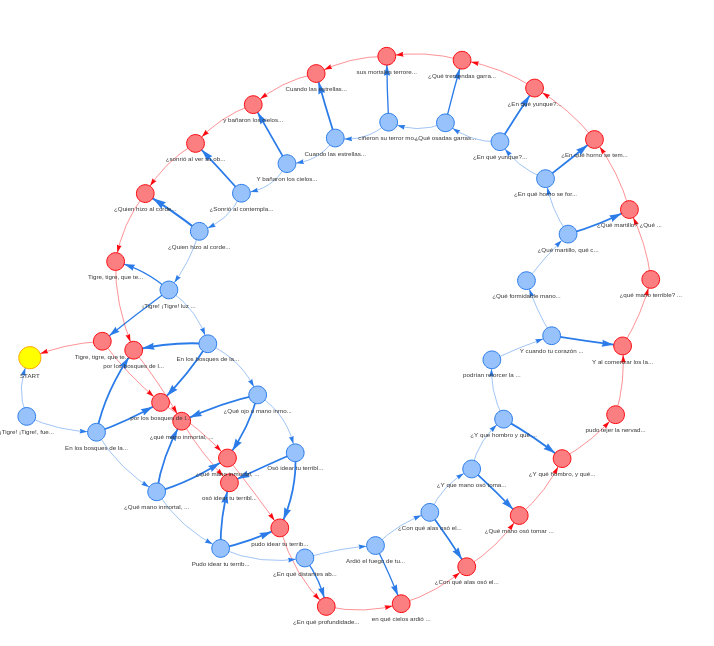